# Práctica Reinforcement Learning

Beatriz Torreiro Mosquera

In [1]:
import ipympl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import gym
import numpy as np
from tqdm import tqdm, trange
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from collections import deque
from collections import namedtuple
import os

### Carga del environment

In [2]:
env = gym.make("Acrobot-v1")
env.seed(123)
torch.manual_seed(123)
np.random.seed(123)

In [3]:
#return height of the given state
def get_height(state):
    cos_a, sin_a, cos_b, sin_b , _ , _ = state
    return -cos_a - (cos_a*cos_b - sin_a*sin_b)

### Double Deep Q-Learning

In [4]:
class DoubleQLearningModel(object):
    def __init__(self, device, num_states, num_actions, learning_rate):
        self._device = device
        self._num_states = num_states
        self._num_actions = num_actions
        self._lr = learning_rate

        # Define the two deep Q-networks
        self.online_model = QNetwork(self._num_states,
                                     self._num_actions).to(device=self._device)
        self.offline_model = QNetwork(
            self._num_states, self._num_actions).to(device=self._device)

        # Define optimizer. Should update online network parameters only.
        self.optimizer = torch.optim.RMSprop(self.online_model.parameters(),
                                             lr=self._lr)

        # Define loss function
        self._mse = nn.MSELoss(reduction='mean').to(device=self._device)

    def calc_loss(self, q_online_curr, q_target, a):
        '''
        Calculate loss for given batch
        :param q_online_curr: batch of q values at current state. Shape (N, num actions)
        :param q_target: batch of temporal difference targets. Shape (N,)
        :param a: batch of actions taken at current state. Shape (N,)
        :return:
        '''
        batch_size = q_online_curr.shape[0]
        assert q_online_curr.shape == (batch_size, self._num_actions)
        assert q_target.shape == (batch_size, )
        assert a.shape == (batch_size, )

        # Select only the Q-values corresponding to the actions taken (loss should only be applied for these)
        q_online_curr_allactions = q_online_curr
        q_online_curr = q_online_curr[torch.arange(batch_size),
                                      a]  # New shape: (batch_size,)
        assert q_online_curr.shape == (batch_size, )
        for j in [0, 3, 4]:
            assert q_online_curr_allactions[j, a[j]] == q_online_curr[j]

        # Make sure that gradient is not back-propagated through Q target
        assert not q_target.requires_grad

        loss = self._mse(q_online_curr, q_target)
        assert loss.shape == ()

        return loss

    def update_target_network(self):
        '''
        Update target network parameters, by copying from online network.
        '''
        online_params = self.online_model.state_dict()
        self.offline_model.load_state_dict(online_params)


In [5]:
class QNetwork(nn.Module):
    def __init__(self, num_states, num_actions):
        super().__init__()
        self._num_states = num_states
        self._num_actions = num_actions

        self._fc_final = nn.Linear(self._num_states, self._num_actions, bias=False)

        # Initialize final layer uniformly in [-1e-6, 1e-6] range, according to old Keras implementation
        nn.init.uniform_(self._fc_final.weight, a=-1e-6, b=1e-6)

    def forward(self, state):
        h=state
        q_values = self._fc_final(h)
        return q_values

In [6]:
class ExperienceReplay:
    def __init__(self, device, num_states, buffer_size=1e+6):
        self._device = device
        self.__buffer = deque(maxlen=int(buffer_size))
        self._num_states = num_states

    @property
    def buffer_length(self):
        return len(self.__buffer)

    def add(self, transition):
        '''
        Adds a transition <s, a, r, s', t > to the replay buffer
        :param transition:
        :return:
        '''
        self.__buffer.append(transition)

    def sample_minibatch(self, batch_size=128):
        '''
        :param batch_size:
        :return:
        '''
        ids = np.random.choice(a=self.buffer_length, size=batch_size)
        state_batch = np.zeros([batch_size, self._num_states],
                               dtype=np.float32)
        action_batch = np.zeros([
            batch_size,
        ], dtype=np.int64)
        reward_batch = np.zeros([
            batch_size,
        ], dtype=np.float32)
        nonterminal_batch = np.zeros([
            batch_size,
        ], dtype=np.bool)
        next_state_batch = np.zeros([batch_size, self._num_states],
                                    dtype=np.float32)
        for i, index in zip(range(batch_size), ids):
            state_batch[i, :] = self.__buffer[index].s
            action_batch[i] = self.__buffer[index].a
            reward_batch[i] = self.__buffer[index].r
            nonterminal_batch[i] = self.__buffer[index].t
            next_state_batch[i, :] = self.__buffer[index].next_s

        return (
            torch.tensor(state_batch, dtype=torch.float, device=self._device),
            torch.tensor(action_batch, dtype=torch.long, device=self._device),
            torch.tensor(reward_batch, dtype=torch.float, device=self._device),
            torch.tensor(next_state_batch,
                         dtype=torch.float,
                         device=self._device),
            torch.tensor(nonterminal_batch,
                         dtype=torch.bool,
                         device=self._device),
        )


In [7]:
def train_loop_ddqn(ddqn, env, replay_buffer, num_episodes, enable_visualization=False, batch_size=64, gamma=.94):        
    Transition = namedtuple("Transition", ["s", "a", "r", "next_s", "t"])
    eps = 0.3#1.
    eps_end = .1 
    eps_decay = 0.995#.001
    tau = 1000
    num_steps = 300
    cnt_updates = 0
    R_buffer = []
    R_avg = []
    max_height_history = []
    for i in range(num_episodes):
        state = env.reset() # Initial state
        state = state[None,:] # Add singleton dimension, to represent as batch of size 1.
        finish_episode = False # Initialize
        ep_reward = 0 # Initialize "Episodic reward", i.e. the total reward for episode, when disregarding discount factor.
        q_buffer = []
        steps = 0
        max_eps_height=-2
        while not finish_episode:
            if enable_visualization:
                env.render() # comment this line out if you don't want to / cannot render the environment on your system
            steps += 1

            # Take one step in environment. No need to compute gradients,
            # we will just store transition to replay buffer, and later sample a whole batch
            # from the replay buffer to actually take a gradient step.
            q_online_curr, curr_action = calc_q_and_take_action(ddqn, state, eps)
            q_buffer.append(q_online_curr)
            new_state, reward, finish_episode, _ = env.step(curr_action) # take one step in the evironment
            new_state = new_state[None,:]
            next_height = get_height(new_state[0])
            if max_eps_height < next_height:
                max_eps_height = next_height 
            
            # Assess whether terminal state was reached.
            # The episode may end due to having reached 200 steps, but we should not regard this as reaching the terminal state, and hence not disregard Q(s',a) from the Q target.
            # https://arxiv.org/abs/1712.00378
            nonterminal_to_buffer = not finish_episode or steps == num_steps
            
            # Store experienced transition to replay buffer
            replay_buffer.add(Transition(s=state, a=curr_action, r=reward, next_s=new_state, t=nonterminal_to_buffer))

            state = new_state
            ep_reward += reward
            
            # If replay buffer contains more than 1000 samples, perform one training step
            if replay_buffer.buffer_length > 1000:
                loss = sample_batch_and_calculate_loss(ddqn, replay_buffer, batch_size, gamma)
                ddqn.optimizer.zero_grad()
                loss.backward()
                ddqn.optimizer.step()

                cnt_updates += 1
                if cnt_updates % tau == 0:
                    ddqn.update_target_network()
                
        #eps = max(eps - eps_decay, eps_end) # decrease epsilon 
        eps = max(eps*eps_decay, eps_end)
        R_buffer.append(ep_reward)
        
        # Running average of episodic rewards (total reward, disregarding discount factor)
        R_avg.append(.05 * R_buffer[i] + .95 * R_avg[i-1]) if i > 0 else R_avg.append(R_buffer[i])
        max_height_history.append(max_eps_height)

        print('Episode: {:d}, Total Reward (running avg): {:4.0f} ({:.2f}) Epsilon: {:.3f}, Avg Q: {:.4g}'.format(
            i, ep_reward, R_avg[-1], eps, np.mean(np.array(q_buffer))))
        
    return R_buffer, max_height_history


In [8]:
def eps_greedy_policy(q_values, eps):
    policy = np.ones([q_values.shape[0]])
    best_action = np.argmax(q_values)
    policy = eps * policy/len(policy)
    policy[best_action] += 1 - eps
    return policy

In [9]:
def sample_batch_and_calculate_loss(ddqn, replay_buffer, batch_size, gamma):
    '''
    Sample mini-batch from replay buffer, and compute the mini-batch loss
    Inputs:
        ddqn          - DDQN model. An object holding the online / offline Q-networks, and some related methods.
        replay_buffer - Replay buffer object (from which smaples will be drawn)
        batch_size    - Batch size
        gamma         - Discount factor
    Returns:
        Mini-batch loss, on which .backward() will be called to compute gradient.
    '''
    # Sample a minibatch of transitions from replay buffer
    curr_state, curr_action, reward, next_state, nonterminal = replay_buffer.sample_minibatch(batch_size)

    # FYI:
    # ddqn.online_model & ddqn.offline_model are Pytorch modules for online / offline Q-networks, which take the state as input,
    # and output the Q-values for all actions.
    # Input shape (batch_size, num_states). Output shape (batch_size, num_actions).
    
    q_online_curr  = ddqn.online_model(curr_state)
    with torch.no_grad():
        q_online_next  = ddqn.online_model(next_state)
        q_offline_next = ddqn.offline_model(next_state)
    
    q_target = calculate_q_targets(q_online_next, q_offline_next, reward, nonterminal, gamma=gamma)
    q_target = q_target.detach()
    loss = ddqn.calc_loss(q_online_curr, q_target, curr_action)

    return loss


In [10]:
def calc_q_and_take_action(ddqn, state, eps):
    '''
    Calculate Q-values for current state, and take an action according to an epsilon-greedy policy.
    Inputs:
        ddqn   - DDQN model. An object holding the online / offline Q-networks, and some related methods.
        state  - Current state. Numpy array, shape (1, num_states).
        eps    - Exploration parameter.
    Returns:
        q_online_curr   - Q(s,a) for current state s. Numpy array, shape (1, num_actions) or  (num_actions,).
        curr_action     - Selected action (0 or 1, i.e. left or right), sampled from epsilon-greedy policy. Integer.
    '''
    # FYI:
    # ddqn.online_model & ddqn.offline_model are Pytorch modules for online / offline Q-networks, which take the state as input,
    # and output the Q-values for all actions.
    # Input shape (batch_size, num_states). Output shape (batch_size, num_actions).

    state = torch.from_numpy(state).float()
    q_online_curr = ddqn.online_model(state)
    curr_action = np.random.choice( np.arange(len(q_online_curr[0])), p = eps_greedy_policy(q_online_curr[0].detach().cpu().numpy(), eps))
    return q_online_curr.detach().cpu().numpy(), curr_action


In [11]:
def calculate_q_targets(q1_batch, q2_batch, r_batch, nonterminal_batch, gamma=.99):
    '''
    Calculates the Q target used for the loss
    : param q1_batch: Batch of Q(s', a) from online network. FloatTensor, shape (N, num actions)
    : param q2_batch: Batch of Q(s', a) from target network. FloatTensor, shape (N, num actions)
    : param r_batch: Batch of rewards. FloatTensor, shape (N,)
    : param nonterminal_batch: Batch of booleans, with False elements if state s' is terminal and True otherwise. BoolTensor, shape (N,)
    : param gamma: Discount factor, float.
    : return: Q target. FloatTensor, shape (N,)
    '''
    best_actions = np.argmax(q1_batch.detach().cpu().numpy(), axis=1)
    Y = r_batch + nonterminal_batch.float() * gamma * q2_batch[np.arange(q2_batch.shape[0]), best_actions]

    return Y



In [12]:
device = torch.device("cpu")
# Initializations
num_actions = env.action_space.n
num_states = env.observation_space.shape[0]
num_episodes = 1000
batch_size = 128
gamma = 0.99#.94
learning_rate = 0.001#1e-4
enable_visualization = False
# Object holding our online / offline Q-Networks
ddqn = DoubleQLearningModel(device, num_states, num_actions, learning_rate)
replay_buffer = ExperienceReplay(device, num_states)

# Train
reward_history, best_episode_height = train_loop_ddqn(ddqn, env, replay_buffer, num_episodes, enable_visualization=enable_visualization, batch_size=batch_size, gamma=gamma)

Episode: 0, Total Reward (running avg): -500 (-500.00) Epsilon: 0.298, Avg Q: 3.351e-07
Episode: 1, Total Reward (running avg): -500 (-500.00) Epsilon: 0.297, Avg Q: 3.405e-07
Episode: 2, Total Reward (running avg): -121 (-481.05) Epsilon: 0.296, Avg Q: -0.02545
Episode: 3, Total Reward (running avg): -500 (-482.00) Epsilon: 0.294, Avg Q: -0.7453
Episode: 4, Total Reward (running avg): -500 (-482.90) Epsilon: 0.293, Avg Q: -1.036
Episode: 5, Total Reward (running avg): -500 (-483.75) Epsilon: 0.291, Avg Q: -1.684
Episode: 6, Total Reward (running avg): -500 (-484.57) Epsilon: 0.290, Avg Q: -1.855
Episode: 7, Total Reward (running avg): -500 (-485.34) Epsilon: 0.288, Avg Q: -1.538
Episode: 8, Total Reward (running avg): -449 (-483.52) Epsilon: 0.287, Avg Q: -2.386
Episode: 9, Total Reward (running avg): -146 (-466.64) Epsilon: 0.285, Avg Q: -1.332
Episode: 10, Total Reward (running avg): -500 (-468.31) Epsilon: 0.284, Avg Q: -3.422
Episode: 11, Total Reward (running avg): -500 (-469.90)

Episode: 96, Total Reward (running avg): -290 (-228.45) Epsilon: 0.184, Avg Q: -7.519
Episode: 97, Total Reward (running avg): -245 (-229.28) Epsilon: 0.184, Avg Q: -6.451
Episode: 98, Total Reward (running avg): -217 (-228.67) Epsilon: 0.183, Avg Q: -5.664
Episode: 99, Total Reward (running avg): -168 (-225.63) Epsilon: 0.182, Avg Q: -5.799
Episode: 100, Total Reward (running avg): -165 (-222.60) Epsilon: 0.181, Avg Q: -4.77
Episode: 101, Total Reward (running avg): -175 (-220.22) Epsilon: 0.180, Avg Q: -4.987
Episode: 102, Total Reward (running avg): -196 (-219.01) Epsilon: 0.179, Avg Q: -6.722
Episode: 103, Total Reward (running avg): -232 (-219.66) Epsilon: 0.178, Avg Q: -2.855
Episode: 104, Total Reward (running avg): -171 (-217.23) Epsilon: 0.177, Avg Q: -6.154
Episode: 105, Total Reward (running avg): -162 (-214.46) Epsilon: 0.176, Avg Q: -6.718
Episode: 106, Total Reward (running avg): -157 (-211.59) Epsilon: 0.175, Avg Q: -5.773
Episode: 107, Total Reward (running avg): -151 (

Episode: 191, Total Reward (running avg): -167 (-185.22) Epsilon: 0.115, Avg Q: -5.53
Episode: 192, Total Reward (running avg): -151 (-183.50) Epsilon: 0.114, Avg Q: -5.543
Episode: 193, Total Reward (running avg): -153 (-181.98) Epsilon: 0.113, Avg Q: -5.423
Episode: 194, Total Reward (running avg): -184 (-182.08) Epsilon: 0.113, Avg Q: -5.466
Episode: 195, Total Reward (running avg): -202 (-183.08) Epsilon: 0.112, Avg Q: -5.326
Episode: 196, Total Reward (running avg): -155 (-181.67) Epsilon: 0.112, Avg Q: -6.217
Episode: 197, Total Reward (running avg): -184 (-181.79) Epsilon: 0.111, Avg Q: -4.368
Episode: 198, Total Reward (running avg): -259 (-185.65) Epsilon: 0.111, Avg Q: -5.106
Episode: 199, Total Reward (running avg): -190 (-185.87) Epsilon: 0.110, Avg Q: -4.194
Episode: 200, Total Reward (running avg): -184 (-185.77) Epsilon: 0.110, Avg Q: -6.713
Episode: 201, Total Reward (running avg): -197 (-186.33) Epsilon: 0.109, Avg Q: -4.151
Episode: 202, Total Reward (running avg): -1

Episode: 286, Total Reward (running avg): -151 (-179.00) Epsilon: 0.100, Avg Q: -4.662
Episode: 287, Total Reward (running avg): -146 (-177.35) Epsilon: 0.100, Avg Q: -5.159
Episode: 288, Total Reward (running avg): -188 (-177.88) Epsilon: 0.100, Avg Q: -4.944
Episode: 289, Total Reward (running avg): -154 (-176.69) Epsilon: 0.100, Avg Q: -5.51
Episode: 290, Total Reward (running avg): -173 (-176.50) Epsilon: 0.100, Avg Q: -4.118
Episode: 291, Total Reward (running avg): -176 (-176.48) Epsilon: 0.100, Avg Q: -4.276
Episode: 292, Total Reward (running avg): -177 (-176.50) Epsilon: 0.100, Avg Q: -3.823
Episode: 293, Total Reward (running avg): -190 (-177.18) Epsilon: 0.100, Avg Q: -4.024
Episode: 294, Total Reward (running avg): -184 (-177.52) Epsilon: 0.100, Avg Q: -3.819
Episode: 295, Total Reward (running avg): -174 (-177.34) Epsilon: 0.100, Avg Q: -3.687
Episode: 296, Total Reward (running avg): -215 (-179.23) Epsilon: 0.100, Avg Q: -5.27
Episode: 297, Total Reward (running avg): -14

Episode: 381, Total Reward (running avg): -203 (-176.04) Epsilon: 0.100, Avg Q: -3.238
Episode: 382, Total Reward (running avg): -230 (-178.74) Epsilon: 0.100, Avg Q: -3.327
Episode: 383, Total Reward (running avg): -226 (-181.10) Epsilon: 0.100, Avg Q: -3.574
Episode: 384, Total Reward (running avg): -166 (-180.35) Epsilon: 0.100, Avg Q: -4.027
Episode: 385, Total Reward (running avg): -204 (-181.53) Epsilon: 0.100, Avg Q: -4.356
Episode: 386, Total Reward (running avg): -139 (-179.40) Epsilon: 0.100, Avg Q: -5.177
Episode: 387, Total Reward (running avg): -189 (-179.88) Epsilon: 0.100, Avg Q: -3.108
Episode: 388, Total Reward (running avg): -267 (-184.24) Epsilon: 0.100, Avg Q: -3.737
Episode: 389, Total Reward (running avg): -434 (-196.73) Epsilon: 0.100, Avg Q: -6.223
Episode: 390, Total Reward (running avg): -178 (-195.79) Epsilon: 0.100, Avg Q: -5.407
Episode: 391, Total Reward (running avg): -230 (-197.50) Epsilon: 0.100, Avg Q: -6.611
Episode: 392, Total Reward (running avg): -

Episode: 476, Total Reward (running avg): -154 (-169.85) Epsilon: 0.100, Avg Q: -4.64
Episode: 477, Total Reward (running avg): -500 (-186.36) Epsilon: 0.100, Avg Q: -11.54
Episode: 478, Total Reward (running avg): -248 (-189.44) Epsilon: 0.100, Avg Q: -3.391
Episode: 479, Total Reward (running avg): -183 (-189.12) Epsilon: 0.100, Avg Q: -4.222
Episode: 480, Total Reward (running avg): -205 (-189.92) Epsilon: 0.100, Avg Q: -6.254
Episode: 481, Total Reward (running avg): -229 (-191.87) Epsilon: 0.100, Avg Q: -4.886
Episode: 482, Total Reward (running avg): -200 (-192.28) Epsilon: 0.100, Avg Q: -5.442
Episode: 483, Total Reward (running avg): -155 (-190.41) Epsilon: 0.100, Avg Q: -4.823
Episode: 484, Total Reward (running avg): -157 (-188.74) Epsilon: 0.100, Avg Q: -4.504
Episode: 485, Total Reward (running avg): -155 (-187.05) Epsilon: 0.100, Avg Q: -4.742
Episode: 486, Total Reward (running avg): -140 (-184.70) Epsilon: 0.100, Avg Q: -4.983
Episode: 487, Total Reward (running avg): -1

Episode: 571, Total Reward (running avg): -411 (-193.38) Epsilon: 0.100, Avg Q: -7.462
Episode: 572, Total Reward (running avg): -214 (-194.41) Epsilon: 0.100, Avg Q: -6.612
Episode: 573, Total Reward (running avg): -329 (-201.14) Epsilon: 0.100, Avg Q: -1.911
Episode: 574, Total Reward (running avg): -215 (-201.84) Epsilon: 0.100, Avg Q: -5.875
Episode: 575, Total Reward (running avg): -217 (-202.59) Epsilon: 0.100, Avg Q: -2.558
Episode: 576, Total Reward (running avg): -171 (-201.01) Epsilon: 0.100, Avg Q: -4.307
Episode: 577, Total Reward (running avg): -167 (-199.31) Epsilon: 0.100, Avg Q: -4.464
Episode: 578, Total Reward (running avg): -192 (-198.95) Epsilon: 0.100, Avg Q: -3.18
Episode: 579, Total Reward (running avg): -169 (-197.45) Epsilon: 0.100, Avg Q: -4.876
Episode: 580, Total Reward (running avg): -262 (-200.68) Epsilon: 0.100, Avg Q: -4.385
Episode: 581, Total Reward (running avg): -235 (-202.39) Epsilon: 0.100, Avg Q: -4.569
Episode: 582, Total Reward (running avg): -1

Episode: 666, Total Reward (running avg): -151 (-188.54) Epsilon: 0.100, Avg Q: -3.911
Episode: 667, Total Reward (running avg): -165 (-187.37) Epsilon: 0.100, Avg Q: -2.972
Episode: 668, Total Reward (running avg): -182 (-187.10) Epsilon: 0.100, Avg Q: -2.962
Episode: 669, Total Reward (running avg): -309 (-193.19) Epsilon: 0.100, Avg Q: -4.569
Episode: 670, Total Reward (running avg): -190 (-193.03) Epsilon: 0.100, Avg Q: -5.039
Episode: 671, Total Reward (running avg): -140 (-190.38) Epsilon: 0.100, Avg Q: -5.28
Episode: 672, Total Reward (running avg): -162 (-188.96) Epsilon: 0.100, Avg Q: -3.746
Episode: 673, Total Reward (running avg): -170 (-188.01) Epsilon: 0.100, Avg Q: -5.177
Episode: 674, Total Reward (running avg): -143 (-185.76) Epsilon: 0.100, Avg Q: -4.214
Episode: 675, Total Reward (running avg): -244 (-188.67) Epsilon: 0.100, Avg Q: -3.512
Episode: 676, Total Reward (running avg): -187 (-188.59) Epsilon: 0.100, Avg Q: -5.309
Episode: 677, Total Reward (running avg): -2

Episode: 761, Total Reward (running avg): -347 (-182.58) Epsilon: 0.100, Avg Q: -9.947
Episode: 762, Total Reward (running avg): -139 (-180.41) Epsilon: 0.100, Avg Q: -5.294
Episode: 763, Total Reward (running avg): -164 (-179.59) Epsilon: 0.100, Avg Q: -3.902
Episode: 764, Total Reward (running avg): -189 (-180.06) Epsilon: 0.100, Avg Q: -3.592
Episode: 765, Total Reward (running avg): -174 (-179.75) Epsilon: 0.100, Avg Q: -4.3
Episode: 766, Total Reward (running avg): -192 (-180.37) Epsilon: 0.100, Avg Q: -3.602
Episode: 767, Total Reward (running avg): -156 (-179.15) Epsilon: 0.100, Avg Q: -3.607
Episode: 768, Total Reward (running avg): -160 (-178.19) Epsilon: 0.100, Avg Q: -5.093
Episode: 769, Total Reward (running avg): -142 (-176.38) Epsilon: 0.100, Avg Q: -4.44
Episode: 770, Total Reward (running avg): -158 (-175.46) Epsilon: 0.100, Avg Q: -5.11
Episode: 771, Total Reward (running avg): -200 (-176.69) Epsilon: 0.100, Avg Q: -2.849
Episode: 772, Total Reward (running avg): -169 

Episode: 856, Total Reward (running avg): -138 (-200.54) Epsilon: 0.100, Avg Q: -5.158
Episode: 857, Total Reward (running avg): -218 (-201.42) Epsilon: 0.100, Avg Q: -3.337
Episode: 858, Total Reward (running avg): -149 (-198.80) Epsilon: 0.100, Avg Q: -5.031
Episode: 859, Total Reward (running avg): -138 (-195.76) Epsilon: 0.100, Avg Q: -4.66
Episode: 860, Total Reward (running avg): -158 (-193.87) Epsilon: 0.100, Avg Q: -4.342
Episode: 861, Total Reward (running avg): -190 (-193.68) Epsilon: 0.100, Avg Q: -3.217
Episode: 862, Total Reward (running avg): -180 (-192.99) Epsilon: 0.100, Avg Q: -4.672
Episode: 863, Total Reward (running avg): -129 (-189.79) Epsilon: 0.100, Avg Q: -4.178
Episode: 864, Total Reward (running avg): -176 (-189.10) Epsilon: 0.100, Avg Q: -5.453
Episode: 865, Total Reward (running avg): -142 (-186.75) Epsilon: 0.100, Avg Q: -4.781
Episode: 866, Total Reward (running avg): -139 (-184.36) Epsilon: 0.100, Avg Q: -3.713
Episode: 867, Total Reward (running avg): -1

Episode: 951, Total Reward (running avg): -173 (-182.71) Epsilon: 0.100, Avg Q: -3.699
Episode: 952, Total Reward (running avg): -147 (-180.92) Epsilon: 0.100, Avg Q: -4.391
Episode: 953, Total Reward (running avg): -157 (-179.72) Epsilon: 0.100, Avg Q: -4.054
Episode: 954, Total Reward (running avg): -159 (-178.69) Epsilon: 0.100, Avg Q: -5.609
Episode: 955, Total Reward (running avg): -153 (-177.40) Epsilon: 0.100, Avg Q: -3.712
Episode: 956, Total Reward (running avg): -141 (-175.58) Epsilon: 0.100, Avg Q: -5.471
Episode: 957, Total Reward (running avg): -224 (-178.00) Epsilon: 0.100, Avg Q: -3.048
Episode: 958, Total Reward (running avg): -327 (-185.45) Epsilon: 0.100, Avg Q: -9.798
Episode: 959, Total Reward (running avg): -171 (-184.73) Epsilon: 0.100, Avg Q: -3.518
Episode: 960, Total Reward (running avg): -158 (-183.39) Epsilon: 0.100, Avg Q: -3.256
Episode: 961, Total Reward (running avg): -213 (-184.87) Epsilon: 0.100, Avg Q: -3.016
Episode: 962, Total Reward (running avg): -

In [13]:
import seaborn as sns
sns.set()

Text(0, 0.5, 'Height')

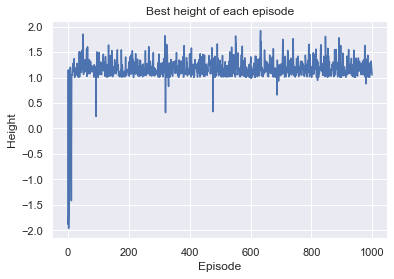

In [14]:
plt.plot(best_episode_height)
plt.title("Best height of each episode")
plt.xlabel("Episode")
plt.ylabel("Height")

Text(0, 0.5, 'Reward')

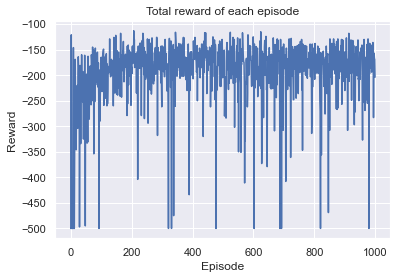

In [15]:
plt.plot(reward_history)
plt.title("Total reward of each episode")
plt.xlabel("Episode")
plt.ylabel("Reward")

In [24]:
def test_run(env, model, n_episodes, n_steps, fps=20, visualization=False):
    #setupvariables
    device = torch.device("cpu")
    fps = 20
    N=n_episodes
    success_growths = []
    first_successful_steps = []
    successful_stepss = []

    for n in range(N):
        state = env.reset()
        steps = n_steps
        successful_steps = 0
        first_successful_step = steps
        success_growth = []
        for i in range(steps):
            if visualization==True:
                time.sleep(1/fps)
                env.render()
            #test by using Q-value from offline network (target network)
            Q = model.offline_model(torch.tensor(state, dtype=torch.float, device=device)).cpu().detach().numpy()
            action = np.argmax(Q)
            state, reward, done, _ = env.step(action)
            current_height = get_height(state)
            #success steps count
            if current_height>1:
                successful_steps += 1
                if first_successful_step > i:
                    first_successful_step=i
            success_growth.append(successful_steps)
        success_growths.append(success_growth)
        first_successful_steps.append(first_successful_step)
        successful_stepss.append(successful_steps)

    print('avg successful steps: {} - {:.4f}%'.format(np.mean(successful_stepss), np.mean(successful_stepss)/steps*100))
    env.close()

    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(1,1,1)
    for n in range(N):
        ax.plot(success_growths[n],'--')
    ax.plot(np.mean(success_growths, axis=0),'.')
    ax.set_title("Average successful steps from {} sample runs".format(N))
    ax.set_xlabel("Steps")
    ax.set_ylabel("Average Successful Steps")
    return np.mean(success_growths, axis=0)

avg successful steps: 23.65 - 7.8833%


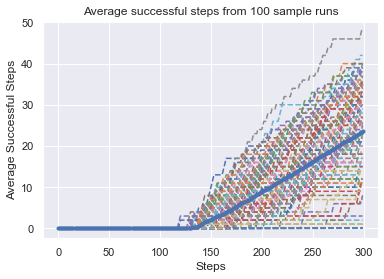

In [25]:
double_avg_success = test_run(env, ddqn, 100, n_steps=300, fps=30, visualization=False)

In [26]:
%store double_avg_success

Stored 'double_avg_success' (ndarray)


In [27]:
np.where(double_avg_success!=0)[0][0]

118

Código basado en la siguientes referencias:
 - https://github.com/PongC/AcrobotRL/blob/master/double_dqn.py